# Deep Fake Detection. Wide ResNet 50-2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import models
import torchvision.transforms as transforms

from torch.optim import lr_scheduler

from torch.utils.data import random_split, DataLoader
from dataset_handlers.feature_dataset import FeatureDataset

import os
from PIL import Image
from matplotlib import pyplot as plt

El modelo Wide ResNet es una arquitectura de red neuronal convolucional que se basa en la idea de mejorar la profundidad de las redes ResNet al hacerlas más anchas. Fue propuesto como una extensión de la arquitectura ResNet con el objetivo de abordar problemas de degradación y facilitar el entrenamiento de redes más profundas.

En lugar de simplemente aumentar la profundidad de la red, el modelo Wide ResNet aumenta la cantidad de canales en cada capa. Esto se logra mediante la introducción de un factor de multiplicación llamado "ancho" (width), que determina la cantidad de canales en comparación con la versión original de la red. El aumento en el ancho permite que la red aprenda características más diversas y complejas, mejorando así su capacidad de generalización.

Para más información sobre el modelo Wide ResNet, se puede consultar el siguiente artículo: [Wide Residual Networks](https://arxiv.org/abs/1605.07146)

Este modelo puede cargarse preentrenado para el dataset de ImageNet directamente desde Pytorch de la siguiente manera:

In [27]:
wide_resnet50_2 = models.wide_resnet50_2(weights='Wide_ResNet50_2_Weights.IMAGENET1K_V1')

## Fine Tuning

In [77]:
model = nn.Sequential(
    wide_resnet50_2.layer4,
    wide_resnet50_2.avgpool,
    nn.Flatten(),
    nn.Dropout(0.5),
    nn.Linear(2048, 2)
)

Comenzamos el proceso de entrenamiento

In [38]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [69]:
def accuracy(data_loader, model, transform):
    acc = 0
    for i, (image, label) in enumerate(data_loader, 1):
        image = image.to(device)
        label = label.to(device)

        image = transform(image)

        output = model(image).reshape(-1, 2)
        acc += (torch.argmax(output, dim=1) == label).sum().item()

    return acc / len(data_loader.dataset)

In [70]:
def train_model(model, transform, criterion, optimizer, epochs, acc_training_set, acc_val_set, l1_factor, train_loader, val_loader):
    for epoch in range(epochs):
        for i, (image, label) in enumerate(train_loader, 1):
            image = image.to(device)
            label = label.to(device)

            image = transform(image)
            output = model(image)

            loss = criterion(output, label)

            l1_regularization = torch.tensor(0., requires_grad=False)
            for param in model.parameters():
                l1_regularization += torch.norm(param, 1)

            l1_regularization.requires_grad_(True)
            loss += l1_factor * l1_regularization

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i % 10 == 0:
                acc_training_set.append(accuracy(train_loader, model, transform))
                acc_val_set.append(accuracy(val_loader, model, transform))

                print('Epoch: {:2.0f}/{}, Batch: {:3.0f}, Loss: {:.6f}, Acc (train): {:.6f}, Acc (val): {:.6f}'
                      .format(epoch+1, epochs, i, loss.item(), acc_training_set[-1], acc_val_set[-1]))

In [41]:
epochs = 10
l1_factor = 0.001
l2_factor = 0.1

In [42]:
critereon = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=l2_factor)

In [59]:
def transform(image):
    return image.reshape(-1, 1024, 14, 14)

In [45]:
acc_training_set = []
acc_val_set = []

for fold in range(1):
    print("Training model for Fold: ", fold+1)
    dataset = FeatureDataset(f"data/splitted/train_widerestnet_data_augmentation/train_{fold}/")

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(dataset=train_dataset, batch_size=120, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True)

    train_model(model, transform, critereon, optimizer, epochs, acc_training_set, acc_val_set, l1_factor, train_loader, val_loader)

Training model for Fold:  1
Epoch:  1/10, Batch:  10, Loss: 8.996345, Acc (train): 0.463739, Acc (val): 0.467347
Epoch:  1/10, Batch:  20, Loss: 8.756674, Acc (train): 0.634321, Acc (val): 0.603061
Epoch:  1/10, Batch:  30, Loss: 8.282947, Acc (train): 0.696118, Acc (val): 0.643878
Epoch:  2/10, Batch:  10, Loss: 8.130583, Acc (train): 0.724464, Acc (val): 0.673469
Epoch:  2/10, Batch:  20, Loss: 8.008567, Acc (train): 0.717824, Acc (val): 0.653061
Epoch:  2/10, Batch:  30, Loss: 7.839174, Acc (train): 0.736721, Acc (val): 0.685714
Epoch:  3/10, Batch:  10, Loss: 7.629067, Acc (train): 0.775792, Acc (val): 0.671429
Epoch:  3/10, Batch:  20, Loss: 7.422189, Acc (train): 0.773238, Acc (val): 0.697959
Epoch:  3/10, Batch:  30, Loss: 7.374764, Acc (train): 0.764300, Acc (val): 0.677551
Epoch:  4/10, Batch:  10, Loss: 7.164130, Acc (train): 0.804648, Acc (val): 0.715306
Epoch:  4/10, Batch:  20, Loss: 7.169055, Acc (train): 0.773238, Acc (val): 0.684694
Epoch:  4/10, Batch:  30, Loss: 7.085

In [56]:
model.eval();

In [55]:
test_dataset = FeatureDataset("data/splitted/test_widerestnet/test/")
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

print("Accuracy on test set: ", accuracy(test_loader, model, transform))

Accuracy on test set:  0.687041564792176


Por último, visualizamos los resultados en una matriz de confusión

In [61]:
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

for i, (image, label) in enumerate(test_loader, 1):
    image = image.to(device)
    label = label.to(device)

    image = transform(image)

    output = model(image)
    y_pred.extend(torch.argmax(output, dim=1).tolist())
    y_true.extend(label.tolist())

cm = confusion_matrix(y_true, y_pred)
f1_score = 2 * cm[1][1] / (2 * cm[1][1] + cm[0][1] + cm[1][0])
print("F1 Score: ", f1_score)

recall = cm[1][1] / (cm[1][1] + cm[1][0])
print("Recall: ", recall)

precision = cm[1][1] / (cm[1][1] + cm[0][1])
print("Precision: ", precision)

acc = (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[1][1] + cm[0][1] + cm[1][0])
print("Accuracy: ", acc)

F1 Score:  0.7229437229437229
Recall:  0.7695852534562212
Precision:  0.6816326530612244
Accuracy:  0.687041564792176


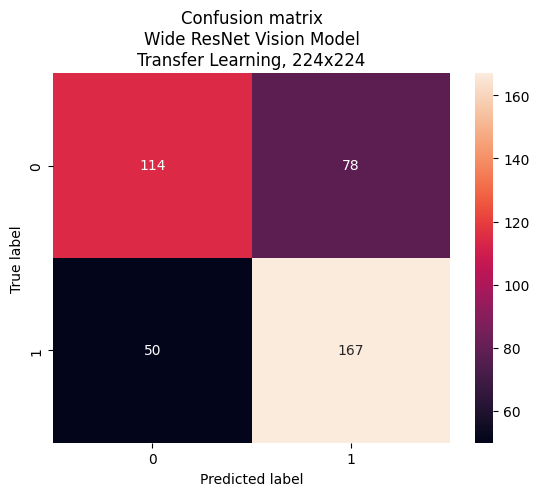

Podemos ver como hemos obtenido unos resultados bastante buenos, pues pese a haber obtenido un ```accuracy``` del 68.7% en el conjunto de test, obtuvimos un ```recall``` del 77%, una ```precision``` del 68.1% y un ```f1-score``` del 72.3% en la detección de deep fakes.

In [63]:
torch.save(model.state_dict(), "models/wide_resnet50_2_10_epochs.pt")